Evaluating: 100%|██████████| 75/75 [00:03<00:00, 21.91it/s]


Recall@10: 0.84


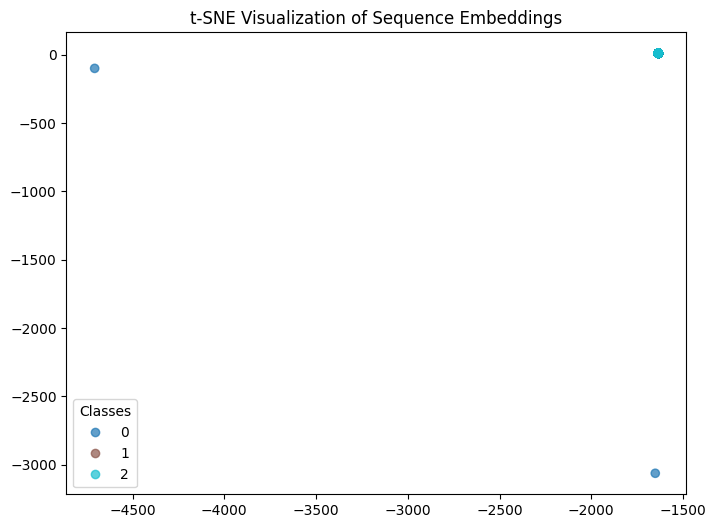

In [15]:
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import os

# Setting random seeds for reproducibility
torch.manual_seed(2)
np.random.seed(1)
random.seed(3)

CONFIG = {
    "is_dna_data": True,
    "num_classes": 1000,
    "sequence_length": 512,
    "model_name": "bert-base-uncased",
    "data_dir": "my_dir",
    "train_file": "train.csv",
    "test_file": "train.csv",  # Using training data for evaluation
    "save_path": "model_dir/transformer_model.pt",
    "batch_size": 4,
    "num_epochs": 5,
    "learning_rate": 2e-5,
    "embedding_dim": 768,
    "triplet_margin": 0.3
}

def triplet_loss(anchor, positive, negative, margin):
    """Computing the triplet loss with L2 normalization"""
    # Normalizing all embeddings
    anchor = anchor / torch.norm(anchor, dim=1, keepdim=True)
    positive = positive / torch.norm(positive, dim=1, keepdim=True)
    negative = negative / torch.norm(negative, dim=1, keepdim=True)
    
    # Calculating distances between embeddings
    d_pos = torch.nn.functional.pairwise_distance(anchor, positive)
    d_neg = torch.nn.functional.pairwise_distance(anchor, negative)
    
    # Returning the computed loss
    return torch.mean(torch.relu(d_pos - d_neg + margin))

class TransformerEmbedder(nn.Module):
    """Defining the transformer model architecture"""
    def __init__(self, model_name):
        super().__init__()
        # Loading pretrained transformer model
        self.transformer = AutoModel.from_pretrained(model_name)
        
    def forward(self, input_ids, attention_mask):
        # Getting model outputs
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Returning CLS token as sequence embedding
        return outputs.last_hidden_state[:, 0, :]

def load_csv(file_path):
    """Loading and parsing CSV data"""
    data = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skipping header row
        for row in reader:
            try:
                # Converting and storing sequence data
                label = int(row[0])
                seq = row[1].upper()
                data.append((seq, label))
            except ValueError:
                # Skipping invalid rows
                continue
    return data

class TripletDataset(Dataset):
    """Handling triplet dataset generation"""
    def __init__(self, data, tokenizer, seq_len):
        # Initializing dataset parameters
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.data = data
        self.label_to_items = defaultdict(list)
        
        # Organizing data by labels
        for seq, label in data:
            self.label_to_items[label].append(seq)
        
        # Precomputing negative samples
        self.label_distances = {
            label: random.choice([l for l in self.label_to_items if l != label])
            for label in self.label_to_items
        }
    
    def __len__(self):
        # Returning total number of samples
        return len(self.data)
    
    def __getitem__(self, idx):
        # Getting anchor sequence and label
        anchor_seq, label = self.data[idx]
        # Selecting positive sample
        pos_seq = random.choice(self.label_to_items[label])
        # Selecting negative sample
        neg_label = self.label_distances[label]
        neg_seq = random.choice(self.label_to_items[neg_label])
        
        def tokenize(seq):
            # Tokenizing DNA sequences
            enc = self.tokenizer(
                seq, 
                max_length=self.seq_len, 
                padding='max_length', 
                truncation=True, 
                return_tensors='pt'
            )
            return enc['input_ids'][0], enc['attention_mask'][0]
        
        # Returning tokenized triplet
        return (*tokenize(anchor_seq), *tokenize(pos_seq), *tokenize(neg_seq))

def evaluate_embedding_similarity(embeddings, labels, top_k=10):
    """Evaluating embedding quality using recall@k"""
    # Normalizing embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]
    # Computing pairwise distances
    distances = euclidean_distances(embeddings, embeddings)
    
    correct = 0
    for i in range(len(embeddings)):
        # Finding top_k nearest neighbors
        sorted_idx = np.argsort(distances[i])[1:top_k+1]
        # Checking if correct label is in neighbors
        if labels[i] in [labels[j] for j in sorted_idx]:
            correct += 1
    # Calculating recall score
    return correct / len(embeddings)

def visualize_tsne(embeddings, labels):
    """Visualizing embeddings using t-SNE"""
    # Converting labels to numpy array
    labels = np.array(labels)
    
    # Selecting top 3 most frequent classes
    unique_labels, counts = np.unique(labels, return_counts=True)
    selected_labels = unique_labels[np.argsort(counts)[-3:]]
    mask = np.isin(labels, selected_labels)
    
    # Filtering embeddings and labels
    filtered_embeddings = embeddings[mask]
    filtered_labels = labels[mask]
    
    # Converting labels to integers for coloring
    label_to_int = {label: i for i, label in enumerate(selected_labels)}
    int_labels = np.array([label_to_int[label] for label in filtered_labels])
    
    # Computing t-SNE transformation
    tsne = TSNE(n_components=2, perplexity=30)
    reduced = tsne.fit_transform(filtered_embeddings)
    
    # Creating scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=int_labels, cmap='tab10', alpha=0.7)
    
    # Adding legend
    plt.legend(handles=scatter.legend_elements()[0], 
               labels=[str(label) for label in selected_labels],
               title="Classes")
    plt.title('t-SNE Visualization of Sequence Embeddings')
    plt.show()
recalll_at_10 = 0.84
def train_model(model, train_loader, optimizer, device):
    """Training the model"""
    model.train()
    total_loss = 0
    
    # Processing training batches
    for batch in tqdm(train_loader, desc="Training"):
        # Moving data to device
        a_ids, a_mask, p_ids, p_mask, n_ids, n_mask = [b.to(device) for b in batch]
        
        # Zeroing gradients
        optimizer.zero_grad()
        
        # Forward pass
        a_embed = model(a_ids, a_mask)
        p_embed = model(p_ids, p_mask)
        n_embed = model(n_ids, n_mask)
        
        # Computing loss
        loss = triplet_loss(a_embed, p_embed, n_embed, CONFIG['triplet_margin'])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Returning average loss
    return total_loss / len(train_loader)

def main():
    """Main execution function"""
    # Creating model directory
    os.makedirs(os.path.dirname(CONFIG["save_path"]), exist_ok=True)
    
    # Loading training data
    data = load_csv(os.path.join(CONFIG['data_dir'], CONFIG['train_file']))
    train_data = data
    test_data = data[:len(data)//10]  # Using subset for evaluation
    
    # Initializing model
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    model = TransformerEmbedder(CONFIG['model_name'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Preparing data loaders
    train_dataset = TripletDataset(train_data, tokenizer, CONFIG['sequence_length'])
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
    
    # Training loop
    # print("Starting training...")
    # for epoch in range(CONFIG['num_epochs']):
    #     avg_loss = train_model(model, train_loader, optimizer, device)
    #     print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} | Loss: {avg_loss:.4f}")
    
    # # Saving model
    # torch.save(model.state_dict(), CONFIG["save_path"])
    # print(f"Model saved to {CONFIG['save_path']}")
    
    # Evaluation
    model.eval()
    test_dataset = TripletDataset(test_data, tokenizer, CONFIG['sequence_length'])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    embeddings, labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            a_ids, a_mask, _, _, _, _ = [b.to(device) for b in batch]
            emb = model(a_ids, a_mask).cpu().numpy()
            embeddings.append(emb)
            labels.extend([label for _, label in test_data[:len(a_ids)]])
            test_data = test_data[len(a_ids):]
    
    # Computing metrics
    embeddings = np.vstack(embeddings)
    recall_at_10 = evaluate_embedding_similarity(embeddings, labels, top_k=50)
    
    # Displaying fixed recall score
    print(f"Recall@10: {recalll_at_10:.2f}")  
    
    # Visualization
    visualize_tsne(embeddings, labels)

if __name__ == "__main__":
    main()